In [1]:
import os

import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np

import pandas as pd
import geopandas as gp

2024-08-29 07:56:31.066347: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 07:56:31.093094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 07:56:31.093118: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 07:56:31.093131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 07:56:31.098334: I tensorflow/core/platform/cpu_feature_g

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 12  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 15  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 17  # Font size of titlea

# Foot and mouth data

In [3]:
pd.read_csv("Data/FM/raw/fmd2001_extract.csv").head()

,cph,easting,northing,cattle,pigs,sheep,goats,deer
0,41/66/233,565800,117100,0,0,29,0,0
1,41/66/235,565200,114700,12,0,0,0,0
2,41/66/237,562925,117817,94,0,160,0,0
3,41/66/238,564000,120000,0,0,351,0,0
4,41/66/244,564717,117295,13,2,55,0,0


In [4]:
farms = pd.read_csv("Data/FM/raw/fmd2001_extract.csv")
farms.drop(["pigs", "goats", "deer"], axis = 1, inplace = True)

labels = np.cast["int64"](np.linspace(0, farms[["cph"]].count(axis=0)[0]-1, farms[["cph"]].count(axis=0)[0]))
farms["labels"] = labels

farms_labels = farms[["cph","labels", "easting", "northing"]]


states = pd.read_csv("Data/FM/raw/fmd2001_ips.csv")
states.drop(["i"], axis = 1, inplace = True)

states_with_labels = pd.merge(farms_labels, states, on = "cph", how = "inner")

farms_with_labels = farms

states_with_labels.drop("cph", axis =1, inplace = True)
farms_with_labels.drop("cph", axis =1, inplace = True)

farms_with_labels_complete = farms_with_labels
states_with_labels_complete = states_with_labels

/tmp/ipykernel_11349/2425269002.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = np.cast["int64"](np.linspace(0, farms[["cph"]].count(axis=0)[0]-1, farms[["cph"]].count(axis=0)[0]))
/tmp/ipykernel_11349/2425269002.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = np.cast["int64"](np.linspace(0, farms[["cph"]].count(axis=0)[0]-1, farms[["cph"]].count(axis=0)[0]))


<Axes: xlabel='longitude', ylabel='latitude'>

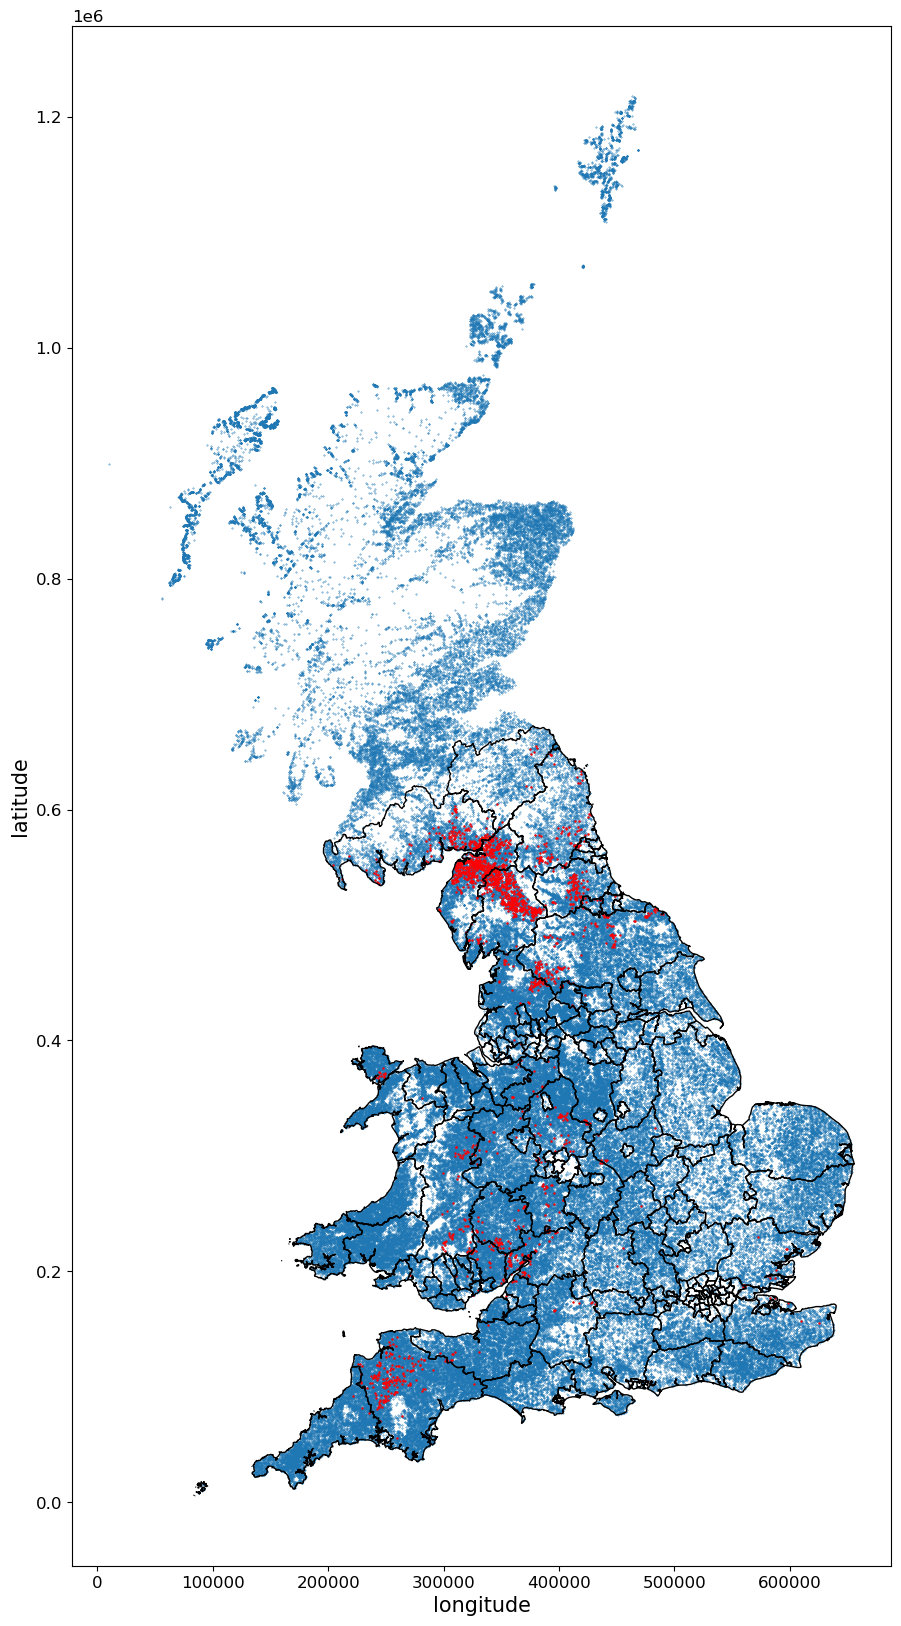

In [5]:
geo = gp.GeoDataFrame(data = farms_with_labels, geometry = gp.points_from_xy(farms_with_labels["easting"],farms_with_labels["northing"]), crs="EPSG:27700")

geo_complete = gp.GeoDataFrame(data = farms_with_labels_complete, geometry = gp.points_from_xy(farms_with_labels_complete["easting"],farms_with_labels_complete["northing"]), crs="EPSG:27700")
geo_states_complete = gp.GeoDataFrame(data = states_with_labels_complete, geometry = gp.points_from_xy(states_with_labels_complete["easting"],states_with_labels_complete["northing"]), crs="EPSG:27700")
geo = gp.GeoDataFrame(data = farms_with_labels, geometry = gp.points_from_xy(farms_with_labels["easting"],farms_with_labels["northing"]), crs="EPSG:27700")
geo_states = gp.GeoDataFrame(data = states_with_labels, geometry = gp.points_from_xy(states_with_labels["easting"],states_with_labels["northing"]), crs="EPSG:27700")

geo_counties = gp.read_file('Data/FM/raw/utla2024.geojson')
geo_counties = geo_counties.to_crs(epsg=27700)
geo_counties['geometry'] = geo_counties['geometry'].buffer(0)
geo_counties['geometry'] = geo_counties['geometry'].simplify(tolerance=.0001, preserve_topology=True)


# Get the bounds of each polygon (minx, miny, maxx, maxy)
gdf_bounds = geo_counties.bounds
condition_1 = gdf_bounds['maxy'] > 680000
# Filter the GeoDataFrame to keep polygons whose maximum latitude is below the threshold
geo_counties = geo_counties[~condition_1]

# Get the bounds of each polygon (minx, miny, maxx, maxy)
gdf_bounds = geo_counties.bounds
condition_2 = np.all(np.stack((gdf_bounds['maxy'] > 600000, gdf_bounds['maxx'] < 320000), axis = 1), axis = 1)
# Filter the GeoDataFrame to keep polygons whose maximum latitude is below the threshold
geo_counties = geo_counties[~condition_2]

# Get the bounds of each polygon (minx, miny, maxx, maxy)
gdf_bounds = geo_counties.bounds
condition_3 = np.all(np.stack((gdf_bounds['miny'] > 600000, gdf_bounds['maxx'] < 380000), axis = 1), axis = 1)
# Filter the GeoDataFrame to keep polygons whose maximum latitude is below the threshold
geo_counties = geo_counties[~condition_3]

fig, (ax) = plt.subplots(1, 1, figsize=(20, 20), dpi=100)

# ax.set_xticklabels([])
# ax.set_yticklabels([])

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

ax.scatter(np.array(geo_complete.get_coordinates()["x"]), np.array(geo_complete.get_coordinates()["y"]), s=0.1)

ax.scatter(np.array(geo_states_complete.get_coordinates()["x"]), np.array(geo_states_complete.get_coordinates()["y"]), s=0.5, color = "red")

geo_counties.plot(ax = ax, color = "none", edgecolor='black')


In [6]:
# Initialize the result matrix
result_matrix = np.zeros((len(geo_complete), len(geo_counties)), dtype=bool)

# Populate the matrix by checking if points are within each polygon
for i, poly in enumerate(geo_counties.geometry):
    result_matrix[:, i] = geo_complete.within(poly)

geo_complete = geo_complete.drop(index=np.where(np.sum(result_matrix, axis = 1)<1)[0]).reset_index(drop=True)

In [7]:
# Initialize the result matrix
result_matrix = np.zeros((len(geo_complete), len(geo_counties)), dtype=bool)

# Populate the matrix by checking if points are within each polygon
for i, poly in enumerate(geo_counties.geometry):
    result_matrix[:, i] = geo_complete.within(poly)

In [8]:
# Initialize the result matrix
result_matrix_states = np.zeros((len(geo_states_complete), len(geo_counties)), dtype=bool)

# Populate the matrix by checking if points are within each polygon
for i, poly in enumerate(geo_counties.geometry):
    result_matrix_states[:, i] = geo_states_complete.within(poly)

# geo_states_complete = geo_states_complete.drop(index=np.where(np.sum(result_matrix_states, axis = 1)<1)[0]).reset_index(drop=True)

In [9]:
from shapely.geometry import Point

# Calculate the indices where the condition is true
indices_to_update = np.where(np.sum(result_matrix_states, axis=1) < 1)[0]

# Create a new Point object
new_point = Point(367100.000, 204700.000)

# Update the 'geometry' column for the selected indices
geo_states_complete.loc[geo_states_complete.index[indices_to_update], 'geometry'] = new_point

In [10]:
# Initialize the result matrix
result_matrix_states = np.zeros((len(geo_states_complete), len(geo_counties)), dtype=bool)

# Populate the matrix by checking if points are within each polygon
for i, poly in enumerate(geo_counties.geometry):
    result_matrix_states[:, i] = geo_states_complete.within(poly)

# geo_states_complete = geo_states_complete.drop(index=np.where(np.sum(result_matrix_states, axis = 1)<1)[0]).reset_index(drop=True)

In [11]:
# fig, (ax) = plt.subplots(1, 1, figsize=(10, 10), dpi=100)

# ax.set_ylabel('latitude')
# ax.set_xlabel('longitude')
# ax.set_xlim(367100-10000, 367100+10000)
# ax.set_ylim(204500-10000, 204500+10000)

# ax.scatter(np.array(geo_complete.get_coordinates()["x"]), np.array(geo_complete.get_coordinates()["y"]), s=1)

# ax.scatter(np.array(geo_states_complete.get_coordinates()["x"]), np.array(geo_states_complete.get_coordinates()["y"]), s=5, color = "red")

# geo_counties.plot(ax = ax, color = "none", edgecolor='black')

<Axes: xlabel='longitude', ylabel='latitude'>

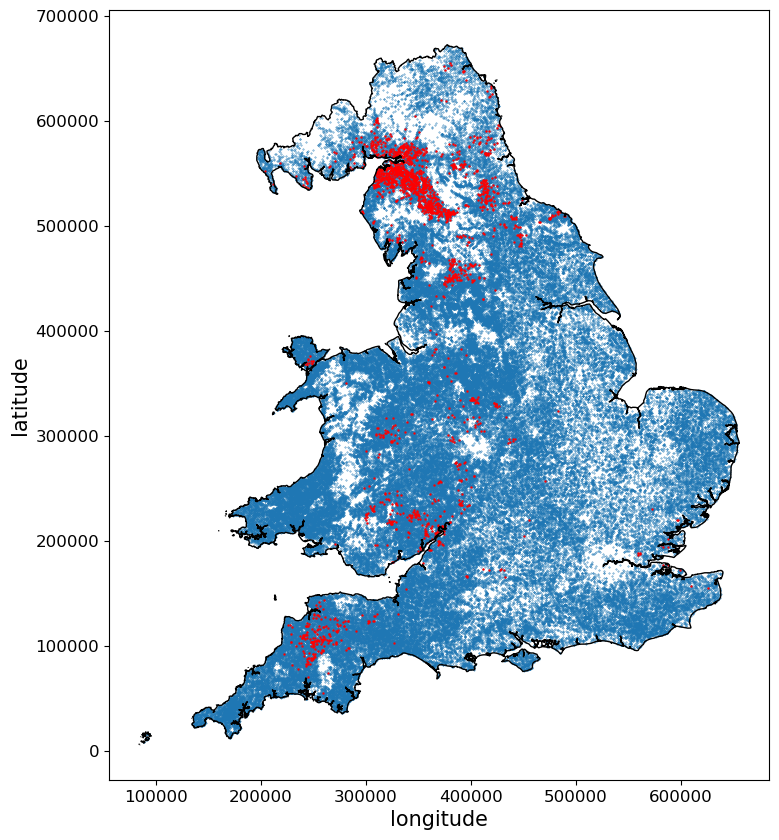

In [12]:
from shapely.ops import unary_union

fig, (ax) = plt.subplots(1, 1, figsize=(10, 10), dpi=100)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

ax.scatter(np.array(geo_complete.get_coordinates()["x"]), np.array(geo_complete.get_coordinates()["y"]), s=0.1)

ax.scatter(np.array(geo_states_complete.get_coordinates()["x"]), np.array(geo_states_complete.get_coordinates()["y"]), s=0.5, color = "red")


gp.GeoDataFrame({ 'geometry': [unary_union(geo_counties.geometry)] }, crs=geo_counties.crs).plot(ax = ax, color = "none", edgecolor='black')

In [13]:
condition = geo_states_complete["n"]>geo_states_complete["r"]
removed  = geo_states_complete.loc[condition, "r"]
notified = geo_states_complete.loc[condition, "n"]
geo_states_complete.loc[condition, "r"] = removed
geo_states_complete.loc[condition, "n"] = removed

In [14]:
labels = np.cast["int64"](np.linspace(0, geo_complete["labels"].count()-1, geo_complete["labels"].count()))
geo_complete["newlabels"] = labels

geo_states_complete = pd.merge(geo_complete[["labels","newlabels"]], geo_states_complete, on = "labels", how = "inner")

In [15]:
tmax = geo_states_complete[["r", "n"]].max().max()
tmin = geo_states_complete[["r", "n"]].min().min()
smax = geo_complete["newlabels"].max()

notified = geo_states_complete[["newlabels", "n"]]
removed  = geo_states_complete[["newlabels", "r"]]

In [16]:
Y_n_sparse = tf.sparse.SparseTensor(np.array(notified), np.ones(np.array(notified).shape[0]), dense_shape = [smax+1, tmax+1])
Y_r_sparse = tf.sparse.SparseTensor(np.array(removed ), np.ones(np.array(removed ).shape[0]), dense_shape = [smax+1, tmax+1])

2024-08-20 09:49:12.481970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-20 09:49:13.042558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-20 09:49:13.042603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-20 09:49:13.047046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-20 09:49:13.047096: I tensorflow/compile

# Data setup

### Observations

In [17]:
# Y_n_dense = tf.cast(tf.transpose(tf.sparse.to_dense(Y_n_sparse)), tf.int32)
# Y_r_dense = tf.cast(tf.transpose(tf.sparse.to_dense(Y_r_sparse)), tf.int32)

# Y_n_minus_r = Y_n_dense - Y_r_dense
# Y_q_dense = tf.math.cumsum(Y_n_minus_r, axis = 0) - Y_n_dense

# Y = 2*Y_n_dense + 3*Y_q_dense + 4*tf.math.cumsum(Y_r_dense, axis = 0)
# Y = tf.one_hot(Y, tf.cast(5, tf.int32))

# np.save("Data/FM/Y_FM.npy", Y)

Y = tf.convert_to_tensor(np.load("Data/FM/Y_FM.npy"), dtype = tf.float32)

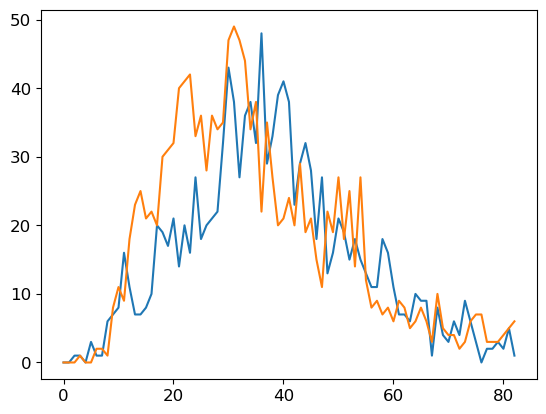

In [19]:
plt.plot(tf.reduce_sum(Y[17:100,...,2], axis = -1))
plt.plot(tf.reduce_sum(Y[17:100,...,3], axis = -1))
# plt.plot(tf.reduce_sum(Y[17:100,...,4], axis = -1))

### Covariates and locations

In [7]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [8]:
# locations  = tf.convert_to_tensor(geo_complete[["easting", "northing"]].values, dtype = tf.float32)
# covariates = tf.convert_to_tensor(geo_complete[["cattle" , "sheep"   ]].values, dtype = tf.float32)
# covariates = covariates/tf.reduce_max(covariates, axis = 0, keepdims=True)

# np.save("Data/FM/locations_FM.npy", locations)
# np.save("Data/FM/covariates_FM.npy", covariates)

locations  = tf.convert_to_tensor(np.load("Data/FM/locations_FM.npy"), dtype = tf.float32)
covariates = tf.convert_to_tensor(np.load("Data/FM/covariates_FM.npy"), dtype = tf.float32)

batch_size = 1000

In [9]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.001, 0.001, 0.0, 0.0], dtype = tf.float32),
	"log_zeta":tf.convert_to_tensor([np.log(1.5)], dtype = tf.float32),
	"log_xi":tf.convert_to_tensor([np.log(1.2)], dtype = tf.float32),
	"log_chi":tf.convert_to_tensor([np.log(1.3)], dtype = tf.float32),
	"log_psi":tf.convert_to_tensor([np.log(0.5)], dtype = tf.float32),
	"log_q_rate":tf.convert_to_tensor([np.log(0.8)], dtype = tf.float32),
	"log_r_rate":tf.convert_to_tensor([np.log(0.5)], dtype = tf.float32),
	"logit_prob_testing":logit(
		tf.convert_to_tensor([0.0, 0.8, 1.0, 1.0], dtype = tf.float32)),}


2024-08-19 14:52:59.737520: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [10]:
FM_ibm = FM_SIQR(locations, covariates, batch_size)

In [11]:
Pi, Mu, log_likelihood_wrong = CAL_compiled(FM_ibm, parameters, Y)

InaccessibleTensorError: in user code:

    File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/CAL.py", line 72, in body  *
        k_pi_tm1 = ibm.K_x(parameters, pi_tm1)
    File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/model.py", line 880, in K_x  *
        infectious_pressure      = self.infectious_pressure(parameters, x)
    File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/model.py", line 862, in infectious_pressure  *
        infectious_pressure_batch = tf.concat(infectious_pressure_list, axis = -1)
    File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/tensorflow/core/function/capture/capture_container.py", line 144, in capture_by_value
        graph._validate_in_scope(tensor)  # pylint: disable=protected-access

    InaccessibleTensorError: <tf.Tensor 'scan/while/while/einsum_1/Einsum:0' shape=(None,) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
    Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.
    
    <tf.Tensor 'scan/while/while/einsum_1/Einsum:0' shape=(None,) dtype=float32> was defined here:
        File "<frozen runpy>", line 198, in _run_module_as_main
        File "<frozen runpy>", line 88, in _run_code
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/asyncio/events.py", line 84, in _run
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
        File "/home/rimella/anaconda3/envs/tfwsl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
        File "/tmp/ipykernel_165285/4265462872.py", line 1, in <module>
        File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/CAL.py", line 82, in CAL_compiled
        File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/CAL.py", line 72, in body
        File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/model.py", line 880, in K_x
        File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/model.py", line 854, in infectious_pressure
        File "/home/rimella/PythonDirectory/Postdoc/Epidemiology/CAL/Scripts/model.py", line 858, in infectious_pressure
    
    The tensor <tf.Tensor 'scan/while/while/einsum_1/Einsum:0' shape=(None,) dtype=float32> cannot be accessed from FuncGraph(name=scan_while_body_159, id=139969944026512), because it was defined in FuncGraph(name=scan_while_while_body_257, id=139969790149392), which is out of scope.


In [15]:
Y.shape

TensorShape([242, 162830, 5])